## Step 1: Import Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score



## Step 2: Load and Inspect the Data

In [9]:
# Load dataset (assuming it's in CSV format)
data = pd.read_csv("customer_churn_dataset-testing-master.csv")

# Inspect the first few rows of the dataset
print(data.head())

# Check for missing values
print(data.isnull().sum())

# Get the data types of the columns
print(data.dtypes)


   CustomerID  Age  Gender  Tenure  Usage Frequency  Support Calls  \
0           1   22  Female      25               14              4   
1           2   41  Female      28               28              7   
2           3   47    Male      27               10              2   
3           4   35    Male       9               12              5   
4           5   53  Female      58               24              9   

   Payment Delay Subscription Type Contract Length  Total Spend  \
0             27             Basic         Monthly          598   
1             13          Standard         Monthly          584   
2             29           Premium          Annual          757   
3             17           Premium       Quarterly          232   
4              2          Standard          Annual          533   

   Last Interaction  Churn  
0                 9      1  
1                20      0  
2                21      0  
3                18      0  
4                18      0  
Cu

## Step 3: Preprocess the Data
##### Handle missing values, encode categorical variables, and scale numerical features.

In [10]:
# Dropping customer ID as it is not useful for prediction
data = data.drop(['CustomerID'], axis=1)

# Handle missing values (for simplicity, dropping rows with missing values)
data = data.dropna()

# Splitting the dataset into features (X) and target (y)
X = data.drop('Churn', axis=1)
y = data['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing steps: OneHotEncoding for categorical and StandardScaler for numerical features
numeric_features = ['Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 
                    'Total Spend', 'Last Interaction']

categorical_features = ['Gender', 'Subscription Type', 'Contract Length']

# Column transformer to apply transformations
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])


## Step 4: Exploratory Data Analysis (EDA)
##### Visualize churn distribution and relationships between features.

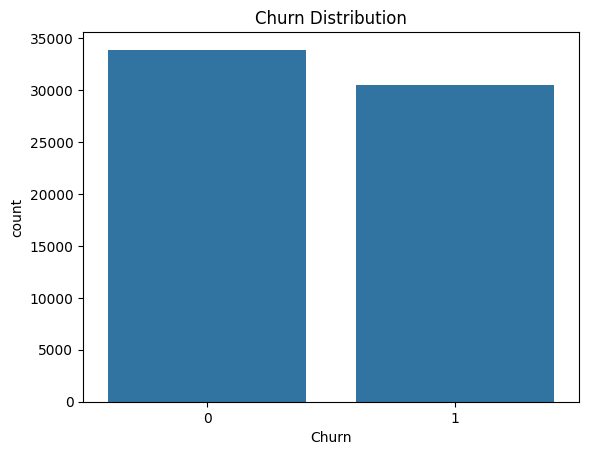

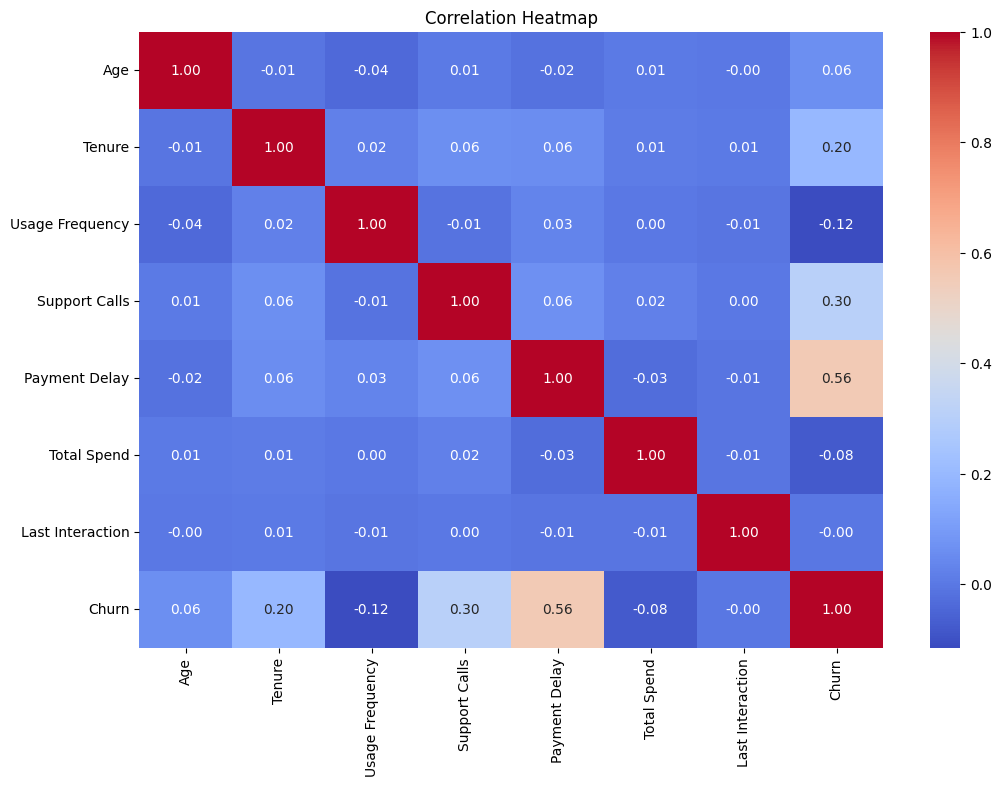

In [12]:
# Visualize the distribution of the target variable
sns.countplot(x='Churn', data=data)
plt.title('Churn Distribution')
plt.show()

# Visualize correlations
# Select only numerical columns for correlation matrix
numerical_data = data.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
correlation_matrix = numerical_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()



## Step 5: Model Building
##### We will start by using Logistic Regression and Random Forest classifiers.

In [13]:
# Logistic Regression Pipeline
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42))
])

# Random Forest Pipeline
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train both models
log_reg_pipeline.fit(X_train, y_train)
rf_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_log_reg = log_reg_pipeline.predict(X_test)
y_pred_rf = rf_pipeline.predict(X_test)

# Get predicted probabilities (for ROC-AUC)
y_pred_log_reg_proba = log_reg_pipeline.predict_proba(X_test)[:, 1]
y_pred_rf_proba = rf_pipeline.predict_proba(X_test)[:, 1]


## Step 6: Model Evaluation

In [14]:
# Logistic Regression Evaluation
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg))
print("Logistic Regression ROC-AUC Score:", roc_auc_score(y_test, y_pred_log_reg_proba))

# Random Forest Evaluation
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Random Forest ROC-AUC Score:", roc_auc_score(y_test, y_pred_rf_proba))


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      6793
           1       0.82      0.83      0.82      6082

    accuracy                           0.83     12875
   macro avg       0.83      0.83      0.83     12875
weighted avg       0.83      0.83      0.83     12875

Logistic Regression ROC-AUC Score: 0.9089260406129238
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6793
           1       1.00      1.00      1.00      6082

    accuracy                           1.00     12875
   macro avg       1.00      1.00      1.00     12875
weighted avg       1.00      1.00      1.00     12875

Random Forest ROC-AUC Score: 0.9999977853093932


## Step 7: Hyperparameter Tuning
##### You can improve model performance by tuning the hyperparameters using GridSearchCV

In [15]:
from sklearn.model_selection import GridSearchCV

# Random Forest Hyperparameter Tuning
param_grid = {
    'classifier__max_depth': [5, 10, 20],
    'classifier__n_estimators': [50, 100, 200]
}

grid_search = GridSearchCV(rf_pipeline, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Best hyperparameters
print(f"Best Parameters: {grid_search.best_params_}")

# Evaluate tuned model
y_pred_rf_tuned = grid_search.best_estimator_.predict(X_test)
y_pred_rf_proba_tuned = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

print("Tuned Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf_tuned))
print("Tuned Random Forest ROC-AUC Score:", roc_auc_score(y_test, y_pred_rf_proba_tuned))


Best Parameters: {'classifier__max_depth': 20, 'classifier__n_estimators': 200}
Tuned Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6793
           1       1.00      1.00      1.00      6082

    accuracy                           1.00     12875
   macro avg       1.00      1.00      1.00     12875
weighted avg       1.00      1.00      1.00     12875

Tuned Random Forest ROC-AUC Score: 0.9999990439313774
